In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
#import all cleaned data -- from sprint 1
numeric_data = pd.read_csv('./num_data.csv')
categorical_data = pd.read_csv('./cat_data.csv')
kyc_data = pd.read_csv('./kyc_data.csv')

# Utilize unsupervised Principal Component analysis algorithim to reduce dimentions

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaler.fit(numeric_data)

C:\Users\omarh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
scaled_data = scaler.transform(numeric_data)

C:\Users\omarh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [9]:
from sklearn.decomposition import PCA

In [10]:
#reduce data variables into 2 components
pca = PCA(n_components=2)

In [11]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
x_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

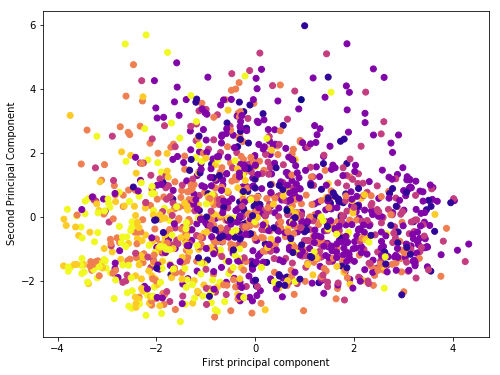

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=numeric_data['Age'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [14]:
df_comp = pd.DataFrame(pca.components_,columns=numeric_data.columns.tolist())

# heatmap to visualize co-relation of each variable to both PCA components

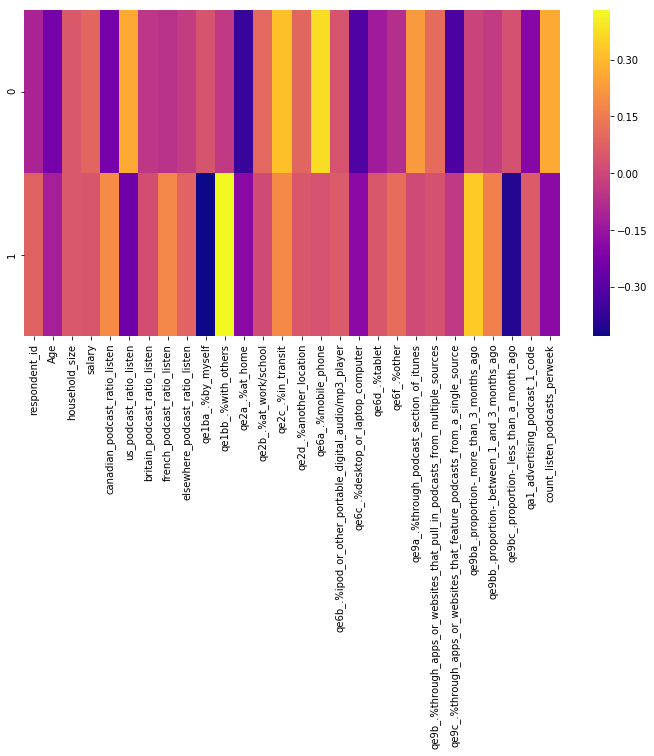

In [15]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

# fit PCA scores into Clustering KMeans unsupervised algorithim

In [16]:
from sklearn.cluster import KMeans

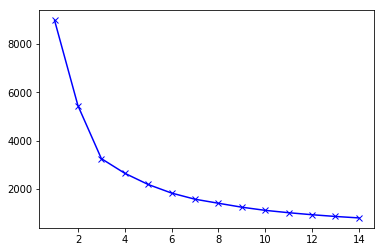

In [18]:
#before we fit the data into the clustering model, we need to determine approporiate number of clusters & for that
#we are going to use sum of squared distances AKA elbow method
sum_of_squared_distances = []

for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit(x_pca)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(range(1,15),sum_of_squared_distances, 'bx-')
plt.show()

### Here in the figure above we can see optimal number of clusters is 3 as after 3 number of clusters doesnt add much value

# KMeans CLUSTERING

In [19]:
kmeans = KMeans(n_clusters=3, init = 'k-means++')

In [20]:
y_kmeans = kmeans.fit_predict(x_pca)

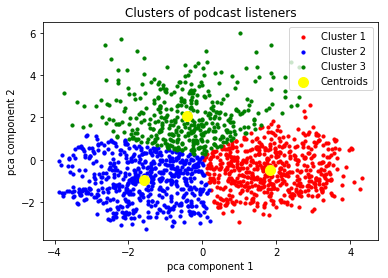

In [21]:
plt.scatter(x_pca[y_kmeans == 0, 0], x_pca[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(x_pca[y_kmeans == 1, 0], x_pca[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(x_pca[y_kmeans == 2, 0], x_pca[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of podcast listeners')
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.legend()
plt.show()

## As you can see in the above figure, there are 3 different clear clusters of podcast listeners

## Now what we have to do is determine the podcast listeners ID and then mine that off the KYC table we have

In [22]:
lables = kmeans.labels_
numeric_data['clusters'] = lables

In [23]:
#assign clusters and their responded id to a variable
num_data_clust = numeric_data[['respondent_id','clusters']]

In [24]:
num_data_clust
merged_keyc_numeric  = kyc_data.merge(num_data_clust, on='respondent_id', how='inner')
kyc_grouping = merged_keyc_numeric[['clusters','salary','Age', 'household_size']].groupby(['clusters',]).mean().astype(int)
kyc_grouping = merged_keyc_numeric[['clusters','salary','Age', 'household_size']].groupby(['clusters',]).mean().astype(int)

In [25]:
size_gp_gender = merged_keyc_numeric.groupby(['clusters','gender']).size().to_frame("total").reset_index()

In [26]:
def get_count_by_column(df, column_name, target_values):
    return len(df[df[column_name] in target_values])    
def get_ratio(df, column_name, filter_name=None, filter_value=None):
    if filter_name is not None:
        print("here")
        df = df[df[filter_name] == filter_value]
        print(len(df))
    df = df[column_name].value_counts(normalize=True).to_frame("percentage") * (100)
    df.rename_axis(column_name, inplace=True)
    return df

# ANALYSIS

### Now, lets take a look at gender ratio in each cluster

here
579
here
557
here
398


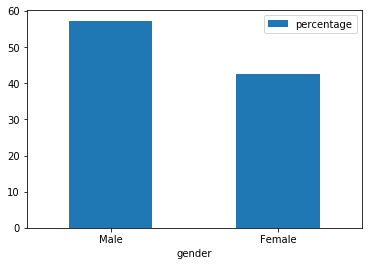

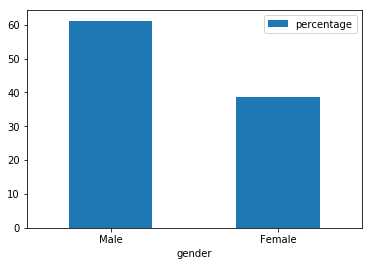

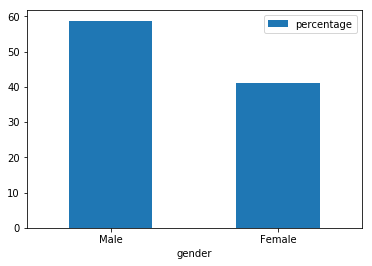

In [27]:
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=0).plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=1).plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=2).plot.bar(rot=0)

We can tell that all 3 clusters share about the same ratio between males & females which is 60% is men & 40% is women.

### Now, lets take a look at top 5 regions ratio in each cluster

here
579
here
557
here
398


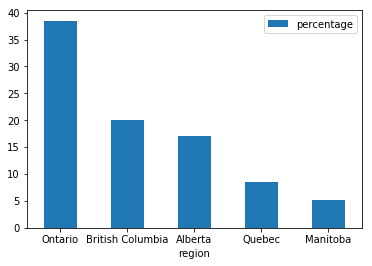

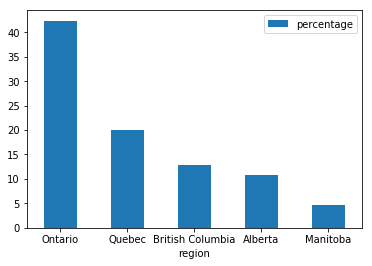

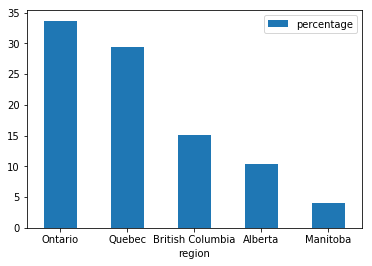

In [28]:
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=0)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=1)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=2)[:5].plot.bar(rot=0)

We can tell that all 2 and 3 clusters share about the same ratio ratio and order of regions. However, cluster one Quebec region is the 2nd most common region among podcast listeners

here
579
here
557
here
398


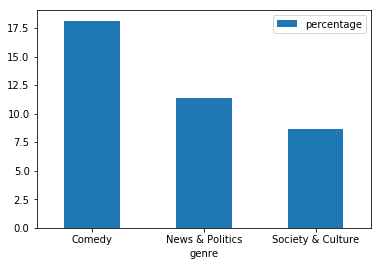

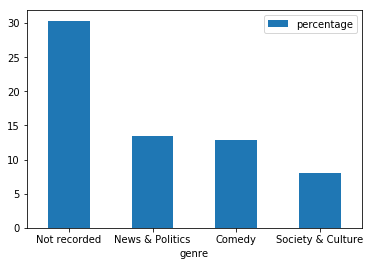

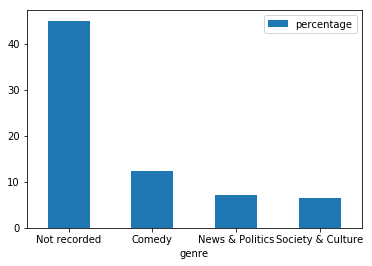

In [29]:
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=0)[:3].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=1)[:4].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=2)[:4].plot.bar(rot=0)

We can tell that cluster one top categories are comedy & news & politics. while cluster 2 & 3 are fairly distributed among most genres.

here
579
here
557
here
398


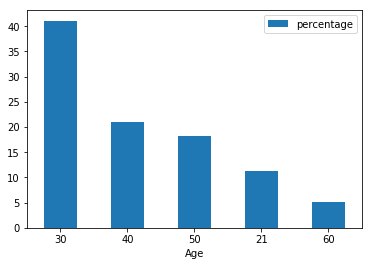

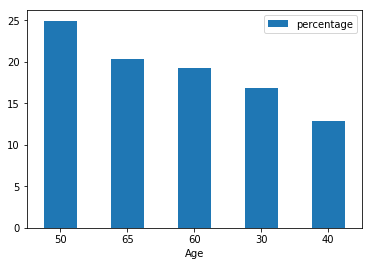

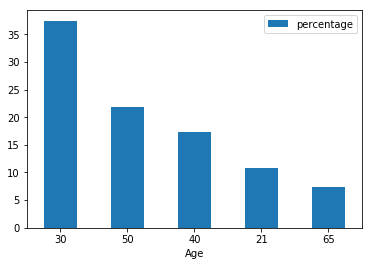

In [30]:
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=0)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=1)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=2)[:5].plot.bar(rot=0)

Here we can tell that majority about (60%) of cluster 1 & 2 age is between 30 to 50 years old. While cluster 3 majority is 50 and above.

# Analysis conclusion

## In conclusion: 

There are 3 segments of podcast listeners.
1. First segment is: 
    a. 60% men & 40% female.
    b. 60% of podcast listenrs reside in either Ontario or British Columbia.
    c. Top podcast category listen to is Comedy and News & Politics.
    d. Top average age is about 30 years old, with 50 years old coming next.
    
2. Second Segmen is:
    a. 60% men & 40% female.
    b. 60% of podcast listenrs reside in either Ontario or Quebec.
    c. They listen equally to most type of categories.
    d. Average age is between 30 to 50 years old.

3. Third cluster is:
    a. 60% men & 40% female.
    b. 60% of podcast listenrs reside in either Ontario or Quebec.
    c. They listen equally to most type of categories.
    d. Average age is above 50-60 years old.

# Next Steps

1. Next steps is to experiment encoding the entire categorical data set and apply PCA then Kmeans.
2. Improve visualizations.
3. Potential web deployment to ad agency so they can determine what category they should advertise on based on input parameters by them such as age, gender, income, etc.